# Extraction of dendritic synapses per unit length for each neuron

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bluepy import Circuit
from bluepy import Cell
from bluepy import Synapse
import neurom as nm
from neurom.core.types import NeuriteType
import progressbar
import time
from joblib import Parallel, delayed
from datetime import datetime
import pandas as pd
import os.path

### Load pre-computed cell table

In [5]:
# If already pre-computed: load from .pkl file
# pkl_file = './cell_table__home_pokorny_circuit-build-S1_v1__2021-02-12_10-38-24.pkl'
# pkl_file = './cell_table__home_pokorny_circuit-build-S1_v1_CircuitConfig__Target_Layer5__2021-04-27_11-50-53.pkl'
# pkl_file = './cell_table__home_pokorny_circuit-build__2021-02-12_09-49-03.pkl'
# pkl_file = './cell_table__SomatosensoryCxS1-v5.r0_O1_merged_circuit__2021-02-12_10-48-04.pkl'
# pkl_file = './cell_table__circuits_Bio_M_20200805_CircuitConfig_TC_WM__2021-03-26_23-22-14.pkl'
pkl_file = './cell_table__pokorny_SSCx_dendritic_synapse_density_SSCxO1_CircuitConfig__Target_hex_O1__2021-04-27_13-07-10.pkl'

cell_table = pd.read_pickle(pkl_file)
circuit_config = os.path.split(os.path.splitext(pkl_file)[0])[1] # Reconstruct circuit config name from pkl_file
circuit_name = circuit_config.split('__')[1] # Reconstruct circuit name from pkl_file
save_date = circuit_config.split('__')[-1] # Reconstruct save date from pkl_file
circuit_target = None if circuit_config.split('__')[2] == save_date else circuit_config.split('__')[2].split('Target_')[-1] # Reconstruct circuit target from pkl_file

In [3]:
# Add combined density
# (incl. midrange)
# sum_columns = {'VPM_syn_density': list(filter(lambda x: 'Thalamocortical_input_VPM' in x and 'density' in x, cell_table.keys())),
#                'POM_syn_density': list(filter(lambda x: 'Thalamocortical_input_POM' in x and 'density' in x, cell_table.keys())),
#                'midrange_syn_density': ['intra_SSCX_midrange_wm_density'],
#                'total_E_syn_density': ['local_E_syn_density', 'midrange_syn_density', 'VPM_syn_density', 'POM_syn_density'],
#                'total_I_syn_density': ['local_I_syn_density']}
# (w/o midrange)
sum_columns = {'VPM_syn_density': list(filter(lambda x: 'Thalamocortical_input_VPM' in x and 'density' in x, cell_table.keys())),
               'POM_syn_density': list(filter(lambda x: 'Thalamocortical_input_POM' in x and 'density' in x, cell_table.keys())),
               'total_E_syn_density': ['local_E_syn_density', 'VPM_syn_density', 'POM_syn_density'],
               'total_I_syn_density': ['local_I_syn_density']}
for (k, v) in sum_columns.items():
    cell_table.insert(column=k, value=np.sum(cell_table[v], 1), loc=cell_table.shape[1])

In [4]:
# # Load reference data and compute density DIFF
# pkl_file_ref = './cell_table__circuits_Bio_M_20200805_CircuitConfig_TC_WM__2021-03-26_23-22-14.pkl'
# cell_table_ref = pd.read_pickle(pkl_file_ref)
# circuit_config = circuit_config + '_DIFF'
# save_date = save_date + '_DIFF'

# for (k, v) in sum_columns.items():
#     cell_table_ref.insert(column=k, value=np.sum(cell_table_ref[v], 1), loc=cell_table_ref.shape[1])

# density_keys = list(filter(lambda x: '_density' in x, cell_table.keys()))
# for k in density_keys:
#     cell_table[k] = cell_table_ref[k] - cell_table[k]

In [4]:
# Commpute missing synapses
ref_density = 1.1 # syn/um [Markram et al. 2015]

cell_table.insert(column='total_E_syn_density_missing', value=ref_density - cell_table['total_E_syn_density'], loc=cell_table.shape[1])
cell_table.insert(column='local_E_syn_density_missing', value=ref_density - cell_table['local_E_syn_density'], loc=cell_table.shape[1])
cell_table.insert(column='total_E_syn_count', value=(cell_table['total_E_syn_density'] * cell_table['total_dendrite_length']).astype(int), loc=cell_table.shape[1])
cell_table.insert(column='total_E_syn_count_missing', value=(cell_table['total_E_syn_density_missing'] * cell_table['total_dendrite_length']).astype(int), loc=cell_table.shape[1])
cell_table.insert(column='local_E_syn_count_missing', value=(cell_table['local_E_syn_density_missing'] * cell_table['total_dendrite_length']).astype(int), loc=cell_table.shape[1])

### Density visualizations

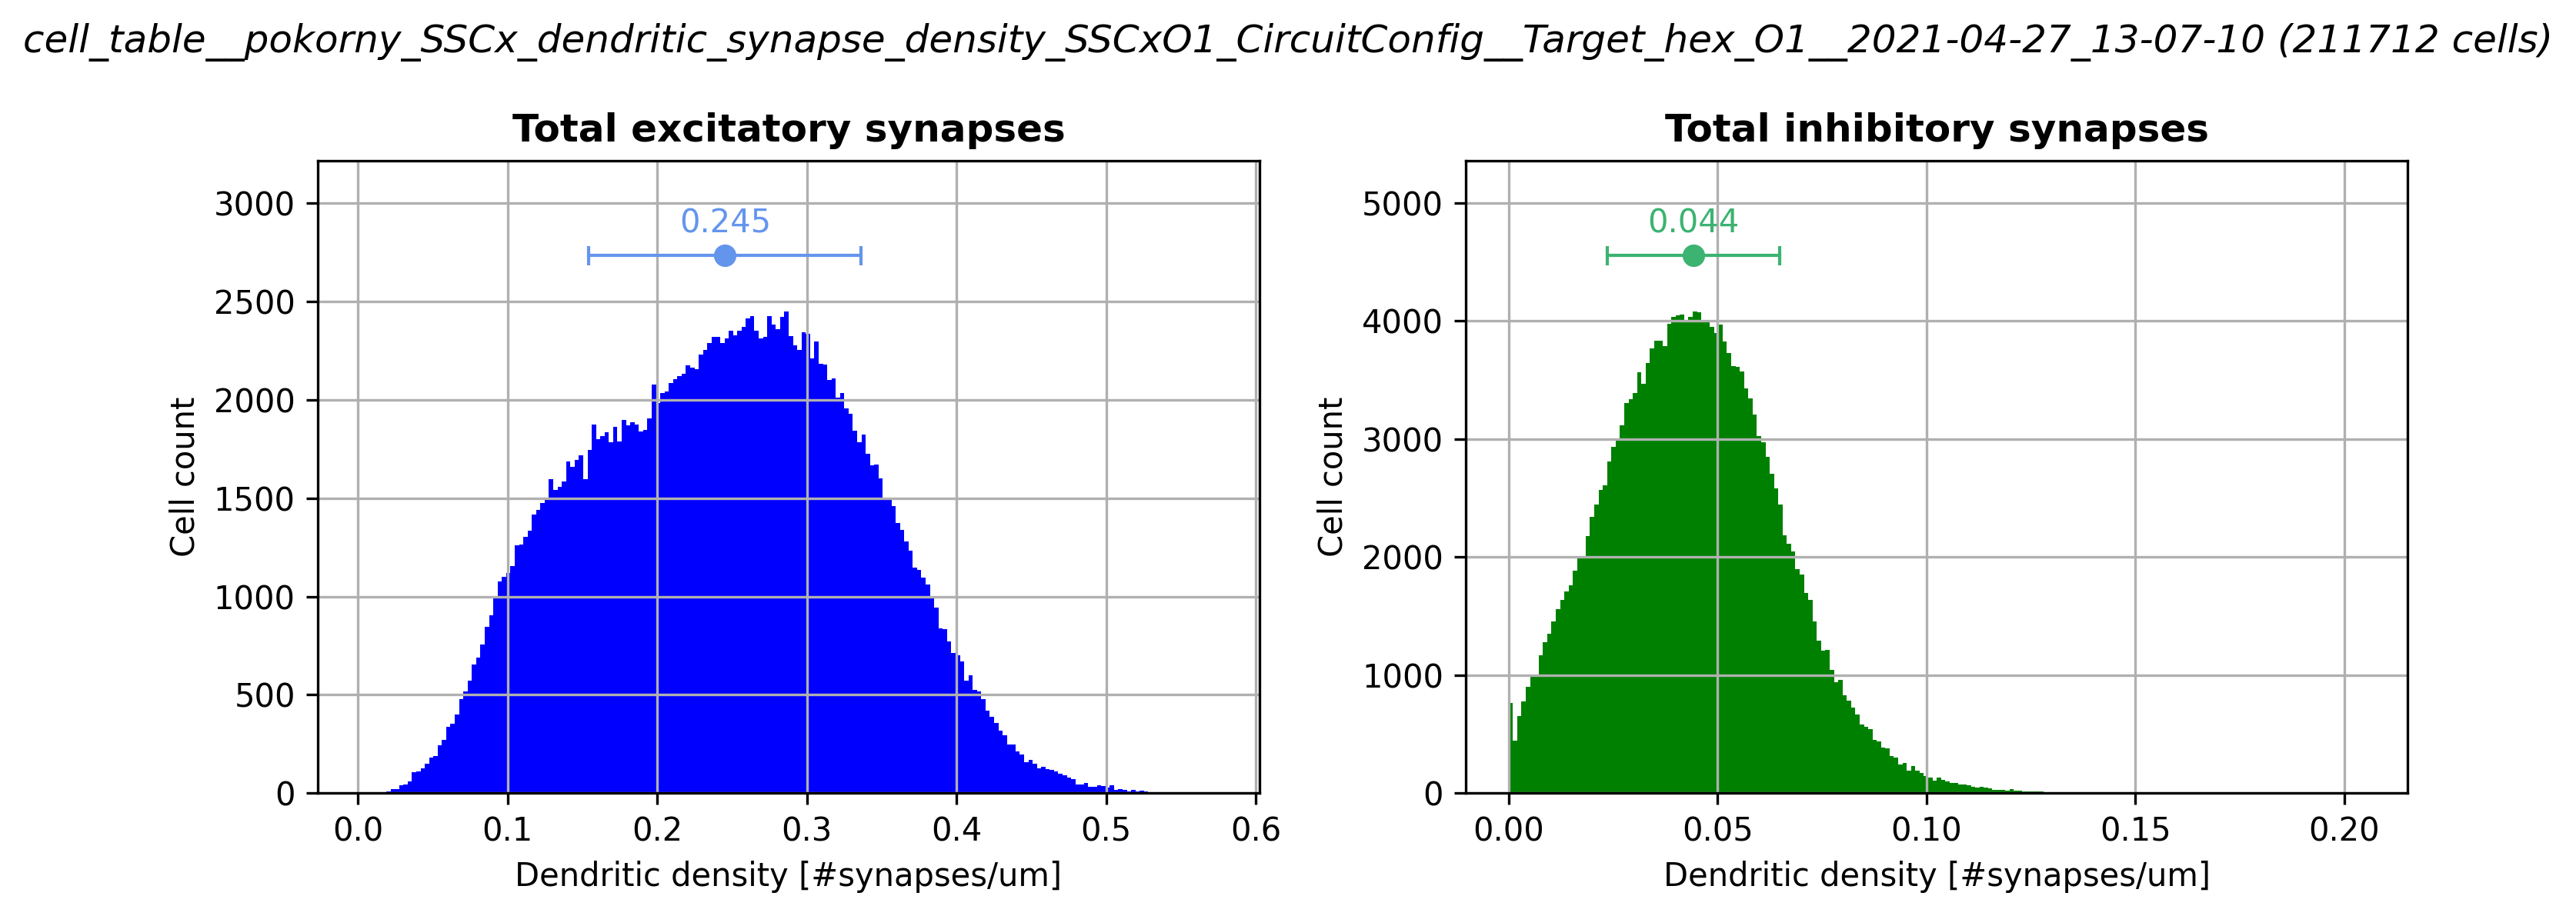

In [4]:
# Density histograms
plot_name = 'Total'
plot_sel = {'excitatory': {'key': 'total_E_syn_density', 'color': 'b', 'meancolor': 'cornflowerblue'},
            'inhibitory': {'key': 'total_I_syn_density', 'color': 'g', 'meancolor': 'mediumseagreen'}}
# plot_name = 'Local'
# plot_sel = {'excitatory': {'key': 'local_E_syn_density', 'color': 'b', 'meancolor': 'cornflowerblue'},
#             'inhibitory': {'key': 'local_I_syn_density', 'color': 'g', 'meancolor': 'mediumseagreen'}}
# plot_name = 'VPM'
# plot_sel = {'excitatory': {'key': 'VPM_syn_density', 'color': 'b', 'meancolor': 'cornflowerblue'},
#             'inhibitory': {'key': '', 'color': 'g', 'meancolor': 'mediumseagreen'}}
# plot_name = 'POM'
# plot_sel = {'excitatory': {'key': 'POM_syn_density', 'color': 'b', 'meancolor': 'cornflowerblue'},
#             'inhibitory': {'key': '', 'color': 'g', 'meancolor': 'mediumseagreen'}}
# plot_name = 'Midrange'
# plot_sel = {'excitatory': {'key': 'midrange_syn_density', 'color': 'b', 'meancolor': 'cornflowerblue'},
#             'inhibitory': {'key': '', 'color': 'g', 'meancolor': 'mediumseagreen'}}

log_count = False
N_bins = 200
bar_pos = 0.25 if log_count else 0.85
density_hist = {}
fig = plt.figure(figsize=(10, 4), dpi=300)
for idx, (name, spec) in enumerate(plot_sel.items()):
    if len(spec['key']) == 0:
        continue
    plt.subplot(1, len(plot_sel), idx + 1)
    density_count, density_bins, _ = plt.hist(cell_table[spec['key']], bins=N_bins, color=spec['color'])
    density_hist[name] = {'count': density_count, 'bins': density_bins}
    if log_count:
        plt.gca().set_yscale('log')
    plt.ylim((min(plt.ylim()), 5 * max(plt.ylim()) if log_count else 1.25 * max(plt.ylim())))
    plt.plot(cell_table[spec['key']].mean(), bar_pos * max(plt.ylim()), 'o', color=spec['meancolor'])
    plt.plot([cell_table[spec['key']].mean() - cell_table[spec['key']].std(), cell_table[spec['key']].mean() + cell_table[spec['key']].std()], np.full(2, bar_pos * max(plt.ylim())), '|-', color=spec['meancolor'], linewidth=1.0)
    plt.text(cell_table[spec['key']].mean(), (bar_pos + 0.025) * max(plt.ylim()), '{:.3f}'.format(cell_table[spec['key']].mean()), color=spec['meancolor'], va='bottom', ha='center')
    plt.xlabel('Dendritic density [#synapses/um]')
    plt.ylabel('Cell count')
    plt.grid()
    plt.title(f'{plot_name} {name} synapses', fontweight='bold')
plt.suptitle(f'{circuit_config} ({cell_table.shape[0]} cells)', fontstyle='italic')
plt.tight_layout()
plt.savefig(f'./density_histograms_{plot_name}{"_log" if log_count else ""}__{circuit_name}__{save_date}.png')


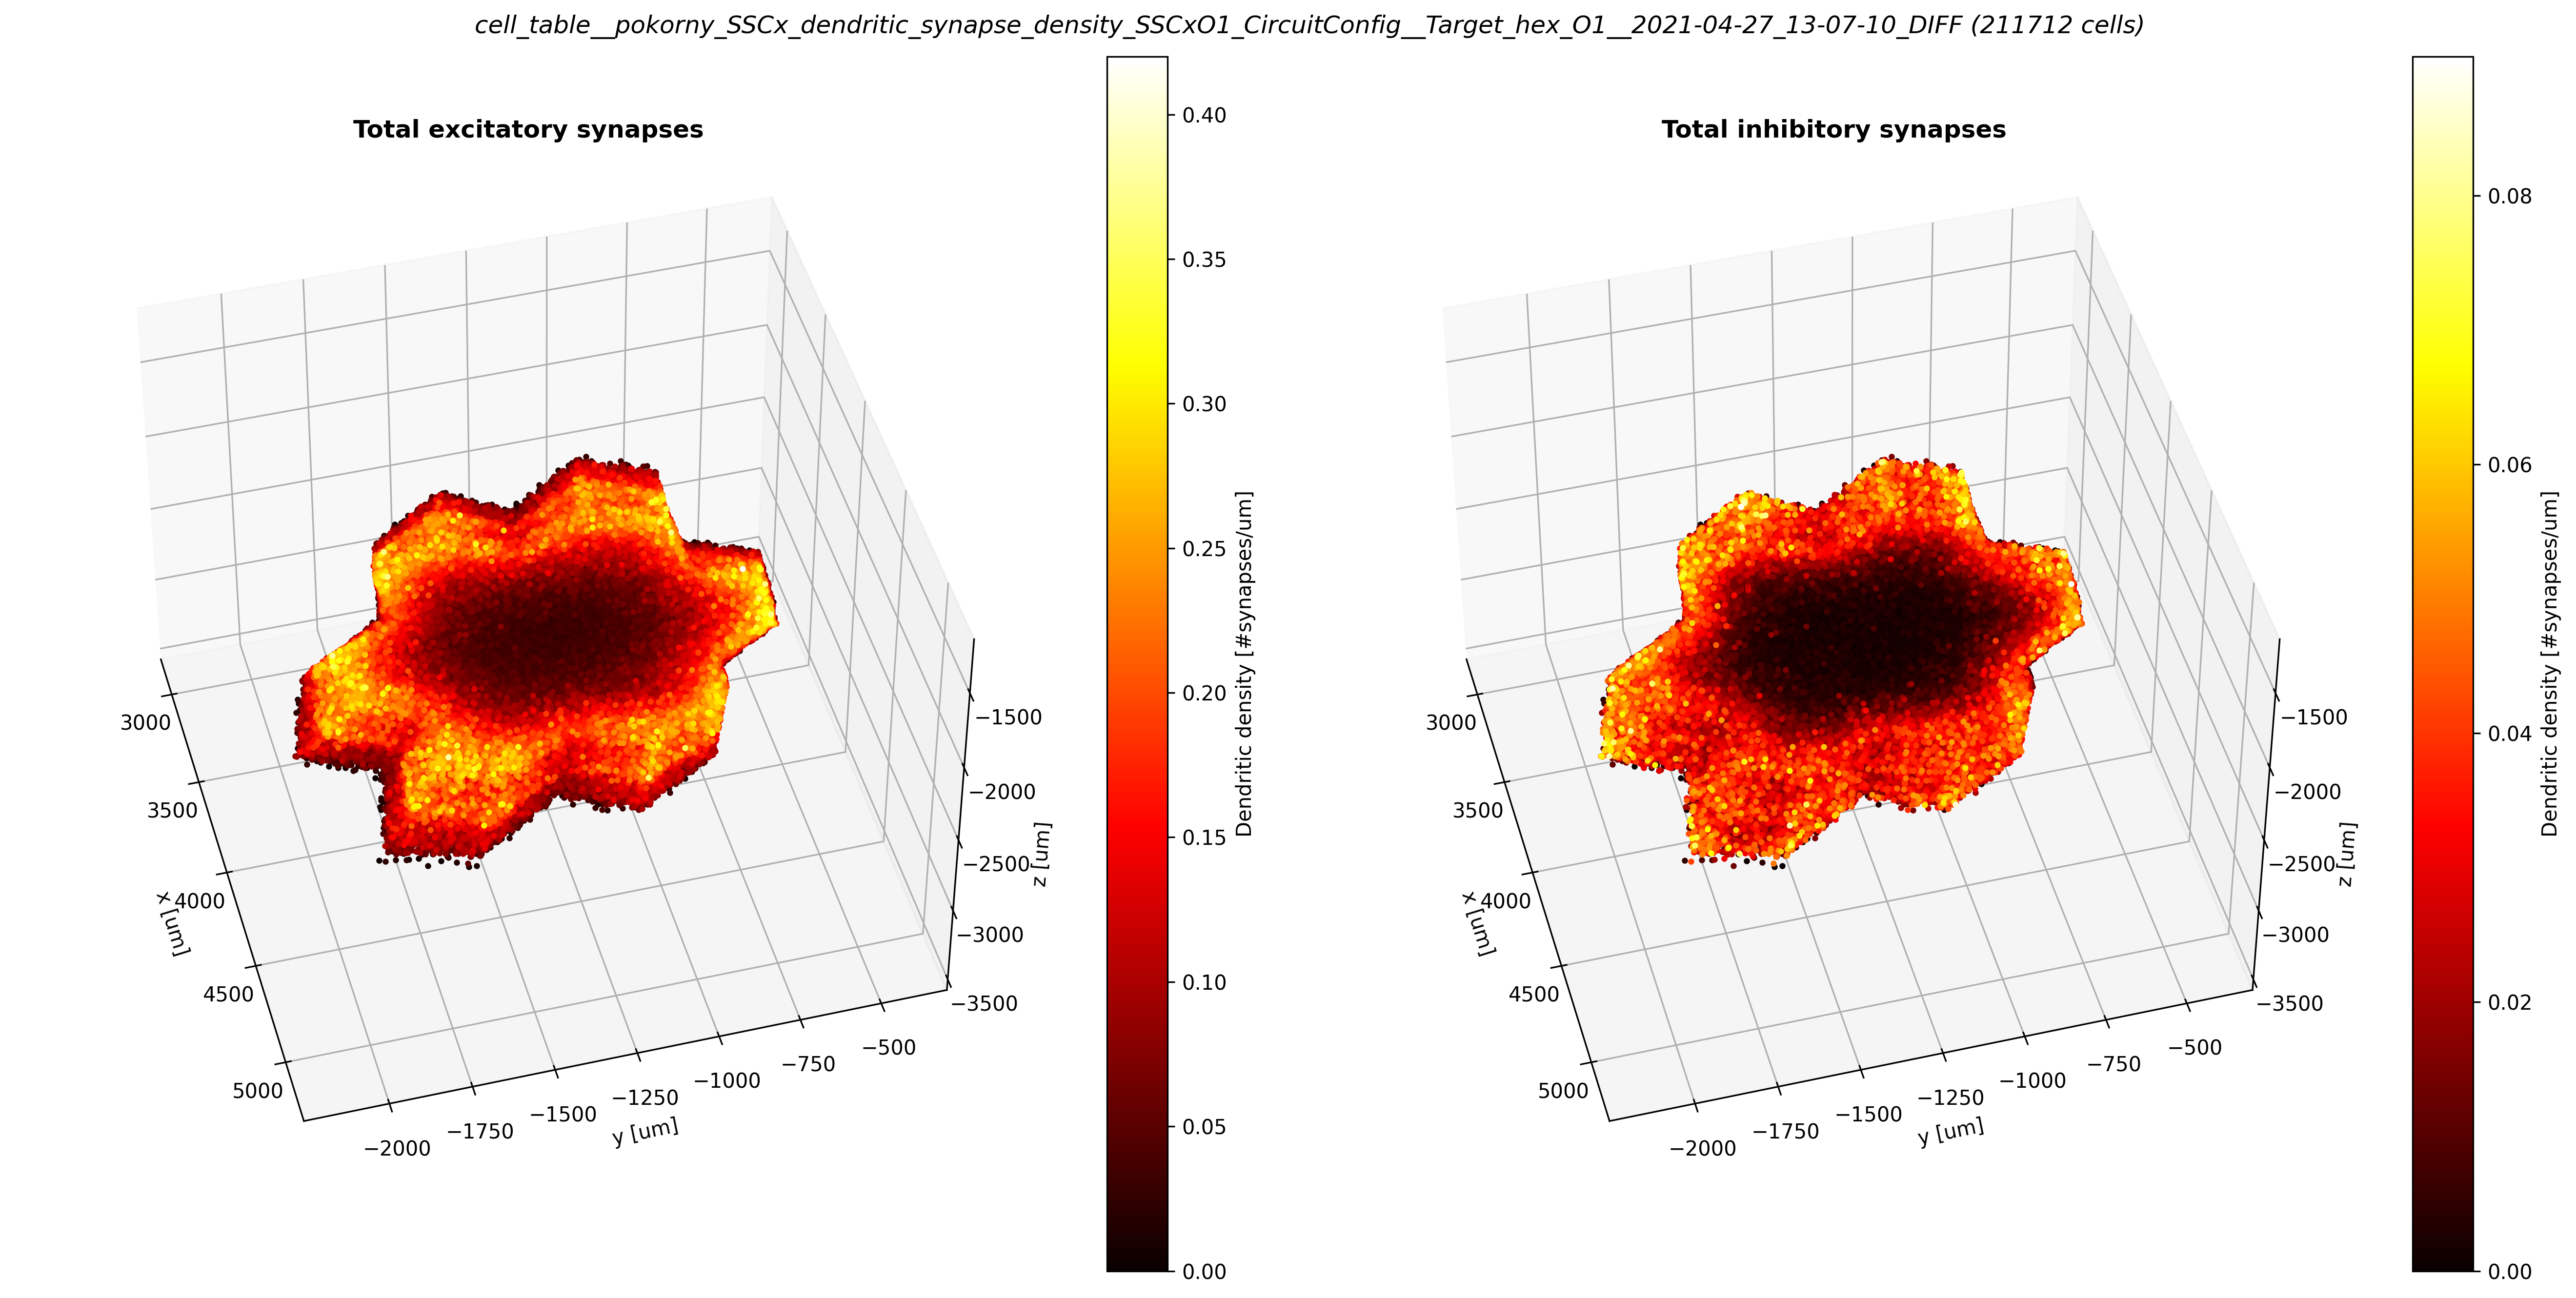

In [32]:
# 3D density plots
fig = plt.figure(figsize=(18, 9), dpi=300)
for idx, (name, spec) in enumerate(plot_sel.items()):
    if not name in density_hist.keys():
        continue
    density_bins = density_hist[name]['bins']
    density_map = plt.cm.ScalarMappable(cmap=plt.cm.hot, norm=plt.Normalize(vmin=density_bins[0], vmax=density_bins[-1]))
    density_colors = density_map.to_rgba(np.linspace(density_bins[0], density_bins[-1], N_bins))
    
    ax = fig.add_subplot(1, 2, idx + 1, projection='3d')
    density_bins[-1] = density_bins[-1] + 1e-12 # Shift rightmost bin edge so that all values are included when using <
    for b in range(N_bins):
        cell_sel = np.logical_and(cell_table[spec['key']] >= density_bins[b], cell_table[spec['key']] < density_bins[b + 1])
        plt.plot(cell_table[cell_sel].x, cell_table[cell_sel].y, cell_table[cell_sel].z, '.', markeredgecolor='none', color=density_colors[b, :])
#     ax.view_init(45, 15)
#     ax.view_init(0, 90)
    ax.view_init(45, -15)
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')
    ax.set_zlabel('z [um]')
    plt.colorbar(density_map, label='Dendritic density [#synapses/um]')
    plt.title(f'{plot_name} {name} synapses', fontweight='bold')
plt.suptitle(f'{circuit_config} ({cell_table.shape[0]} cells)', fontstyle='italic')
plt.tight_layout()
plt.savefig(f'./density_3d_{plot_name}__{circuit_name}__{save_date}.png')


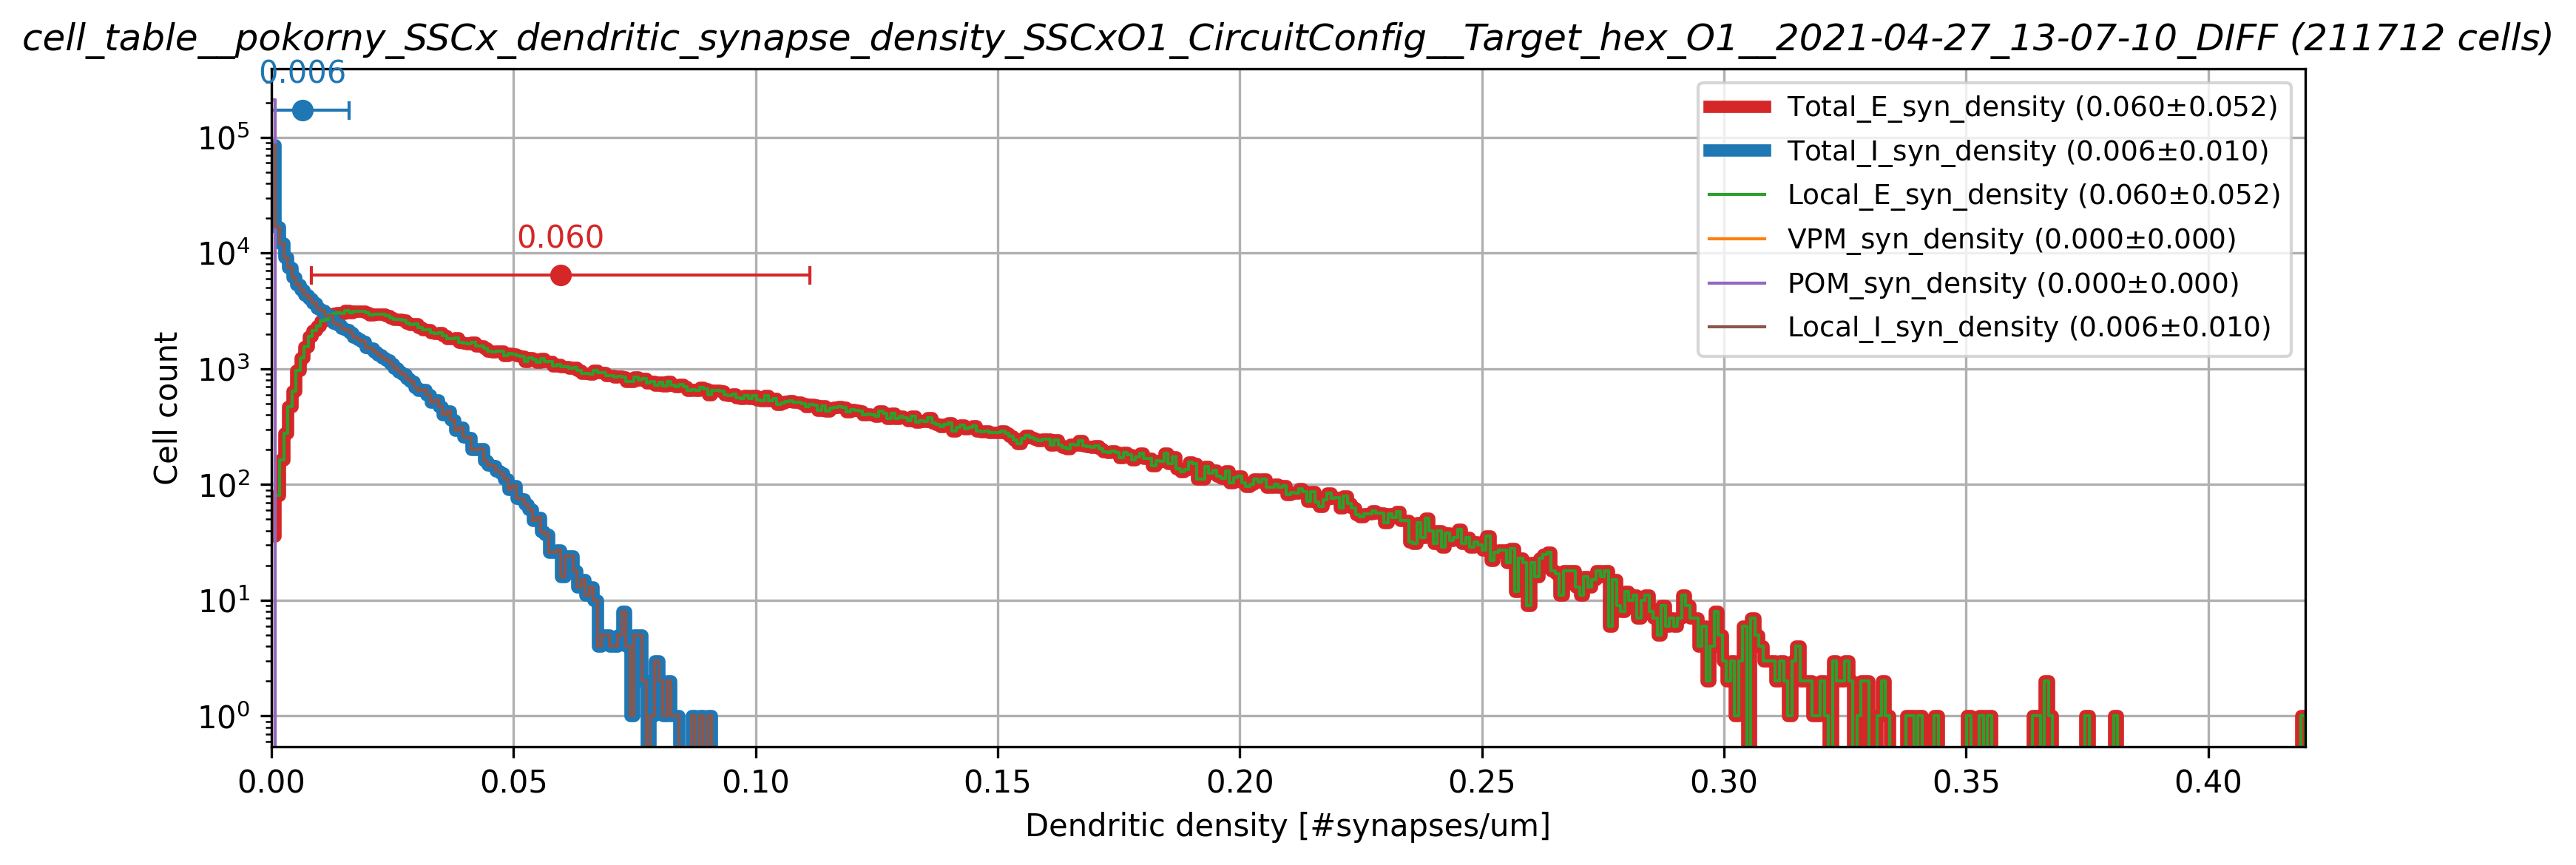

In [33]:
# All density histograms in single plot
# plot_sel = ['total_E_syn_density', 'total_I_syn_density', 'local_E_syn_density', 'VPM_syn_density', 'POM_syn_density', 'midrange_syn_density', 'local_I_syn_density']
plot_sel = ['total_E_syn_density', 'total_I_syn_density', 'local_E_syn_density', 'VPM_syn_density', 'POM_syn_density', 'local_I_syn_density']
highlight_sel = ['total_E_syn_density', 'total_I_syn_density']
colors_sel = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:gray']

bar_pos = 2
bins = np.linspace(0, cell_table[plot_sel].max().max(), 500)
fig = plt.figure(figsize=(10, 4), dpi=300)
for idx, name in enumerate(plot_sel):
    density_count, _ = np.histogram(cell_table[name], bins=bins)
    lbl = f'{name[0].upper() + name[1:]} ({cell_table[name].mean():.3f}$\pm${cell_table[name].std():.3f})'
    if name in highlight_sel:
        plt.step(bins, np.hstack((density_count, 0)),where='post', linewidth=4, color=colors_sel[idx], label=lbl)
        
        plt.plot(cell_table[name].mean(), bar_pos * max(density_count), 'o', color=colors_sel[idx])
        plt.plot([cell_table[name].mean() - cell_table[name].std(), cell_table[name].mean() + cell_table[name].std()], np.full(2, bar_pos * max(density_count)), '|-', color=colors_sel[idx], linewidth=1.0)
        plt.text(cell_table[name].mean(), (bar_pos + 1.0) * max(density_count), '{:.3f}'.format(cell_table[name].mean()), color=colors_sel[idx], va='bottom', ha='center')
    else:
        plt.step(bins, np.hstack((density_count, 0)), where='post', linewidth=1, color=colors_sel[idx], label=lbl)
plt.xlim((bins[0], bins[-1]))
plt.gca().set_yscale('log')
plt.xlabel('Dendritic density [#synapses/um]')
plt.ylabel('Cell count')
plt.grid()
plt.legend(fontsize=9)
plt.title(f'{circuit_config} ({cell_table.shape[0]} cells)', fontstyle='italic')
plt.tight_layout()
plt.savefig(f'./density_histograms_log__{circuit_name}__{save_date}.png')


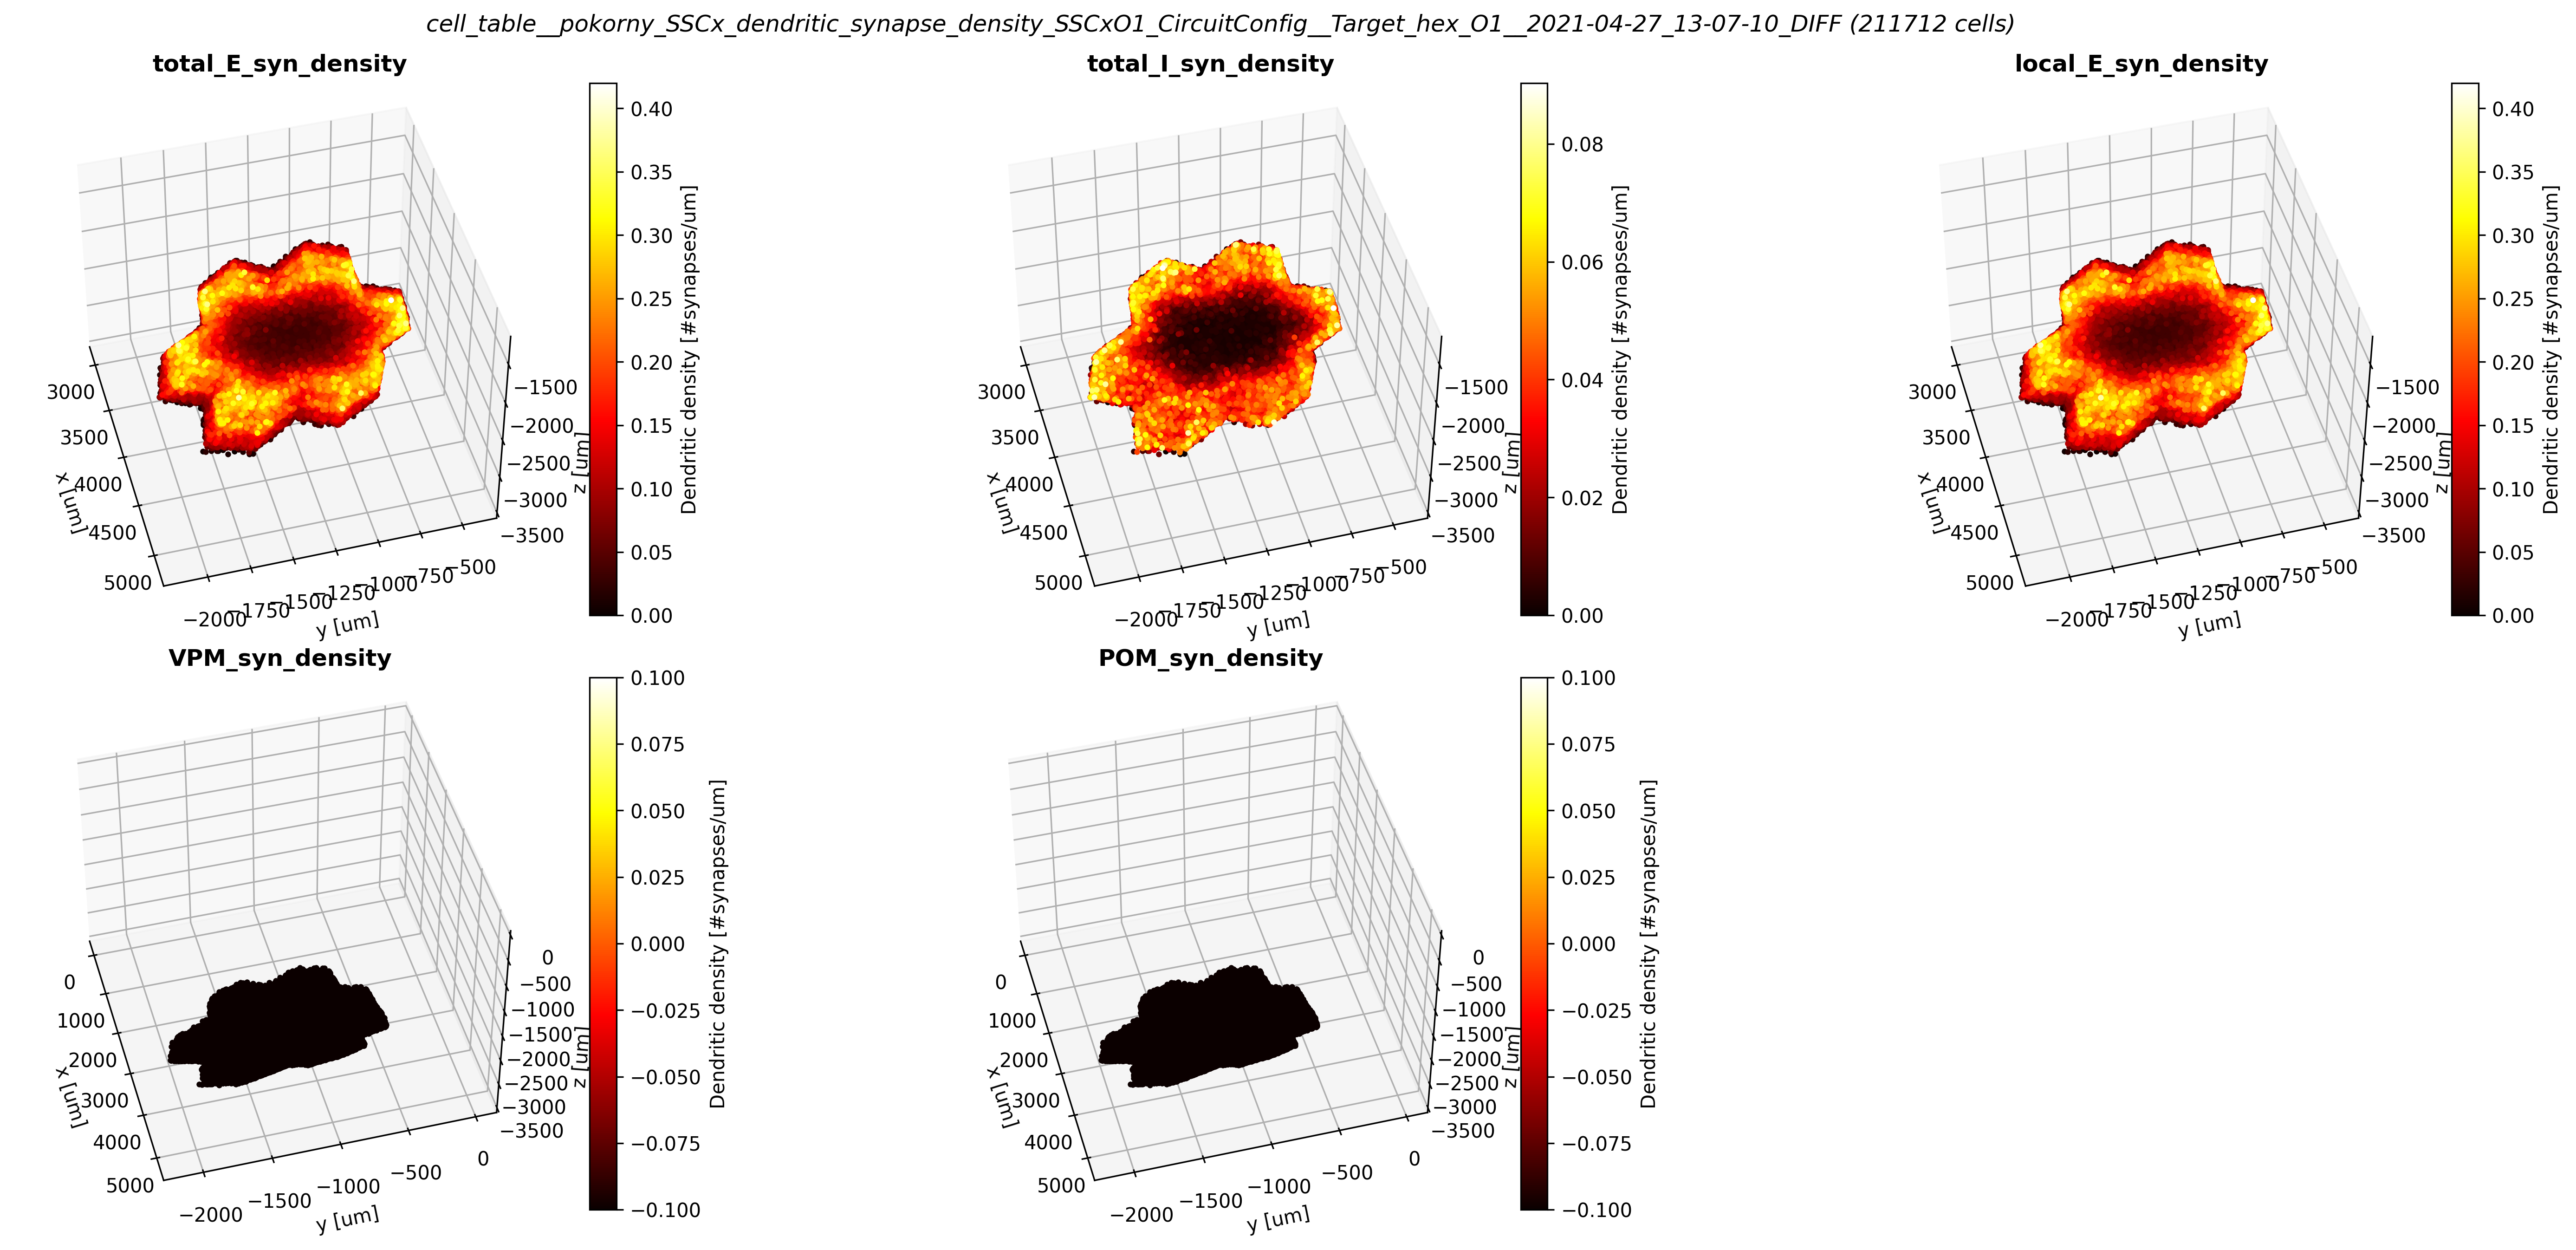

In [34]:
# All 3D densities in single plot
# plot_sel = ['total_E_syn_density', 'total_I_syn_density', 'local_E_syn_density', 'VPM_syn_density', 'POM_syn_density', 'midrange_syn_density']
plot_sel = ['total_E_syn_density', 'total_I_syn_density', 'local_E_syn_density', 'VPM_syn_density', 'POM_syn_density']

grid = [2, 3]
assert np.prod(grid) >= len(plot_sel), 'ERROR: Grid too small!'
N_bins = 100
fig = plt.figure(figsize=(20, 9), dpi=300)
for idx, name in enumerate(plot_sel):
    
    density_bins = np.linspace(0, cell_table[name].max(), N_bins + 1)
    density_map = plt.cm.ScalarMappable(cmap=plt.cm.hot, norm=plt.Normalize(vmin=density_bins[0], vmax=density_bins[-1]))
    density_colors = density_map.to_rgba(np.linspace(density_bins[0], density_bins[-1], N_bins))
    density_bins[-1] = density_bins[-1] + 1e-12 # Shift rightmost bin edge so that all values are included when using <
    
    ax = fig.add_subplot(grid[0], grid[1], idx + 1, projection='3d')
    for b in range(N_bins):
        cell_sel = np.logical_and(cell_table[name] >= density_bins[b], cell_table[name] < density_bins[b + 1])
        plt.plot(cell_table[cell_sel].x, cell_table[cell_sel].y, cell_table[cell_sel].z, '.', markeredgecolor='none', color=density_colors[b, :])
#     ax.view_init(45, 15)
#     ax.view_init(0, 90)
    ax.view_init(45, -15)
    ax.set_xlabel('x [um]')
    ax.set_ylabel('y [um]')
    ax.set_zlabel('z [um]')
    plt.colorbar(density_map, label='Dendritic density [#synapses/um]')
    plt.title(name, fontweight='bold')
plt.suptitle(f'{circuit_config} ({cell_table.shape[0]} cells)', fontstyle='italic')
plt.tight_layout()
plt.savefig(f'./density_3d__{circuit_name}__{save_date}.png')


In [ ]:
# Load additional cell properties
# circuit = Circuit('/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig')
# circuit = Circuit('/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/CircuitConfig')
circuit = Circuit('/gpfs/bbp.cscs.ch/project/proj83/home/pokorny/SSCx/dendritic_synapse_density/SSCxO1_CircuitConfig')
cell_ids = circuit.cells.ids(circuit_target)
assert np.all(cell_ids == cell_table.index), 'ERROR: Cell ids mismatch!'

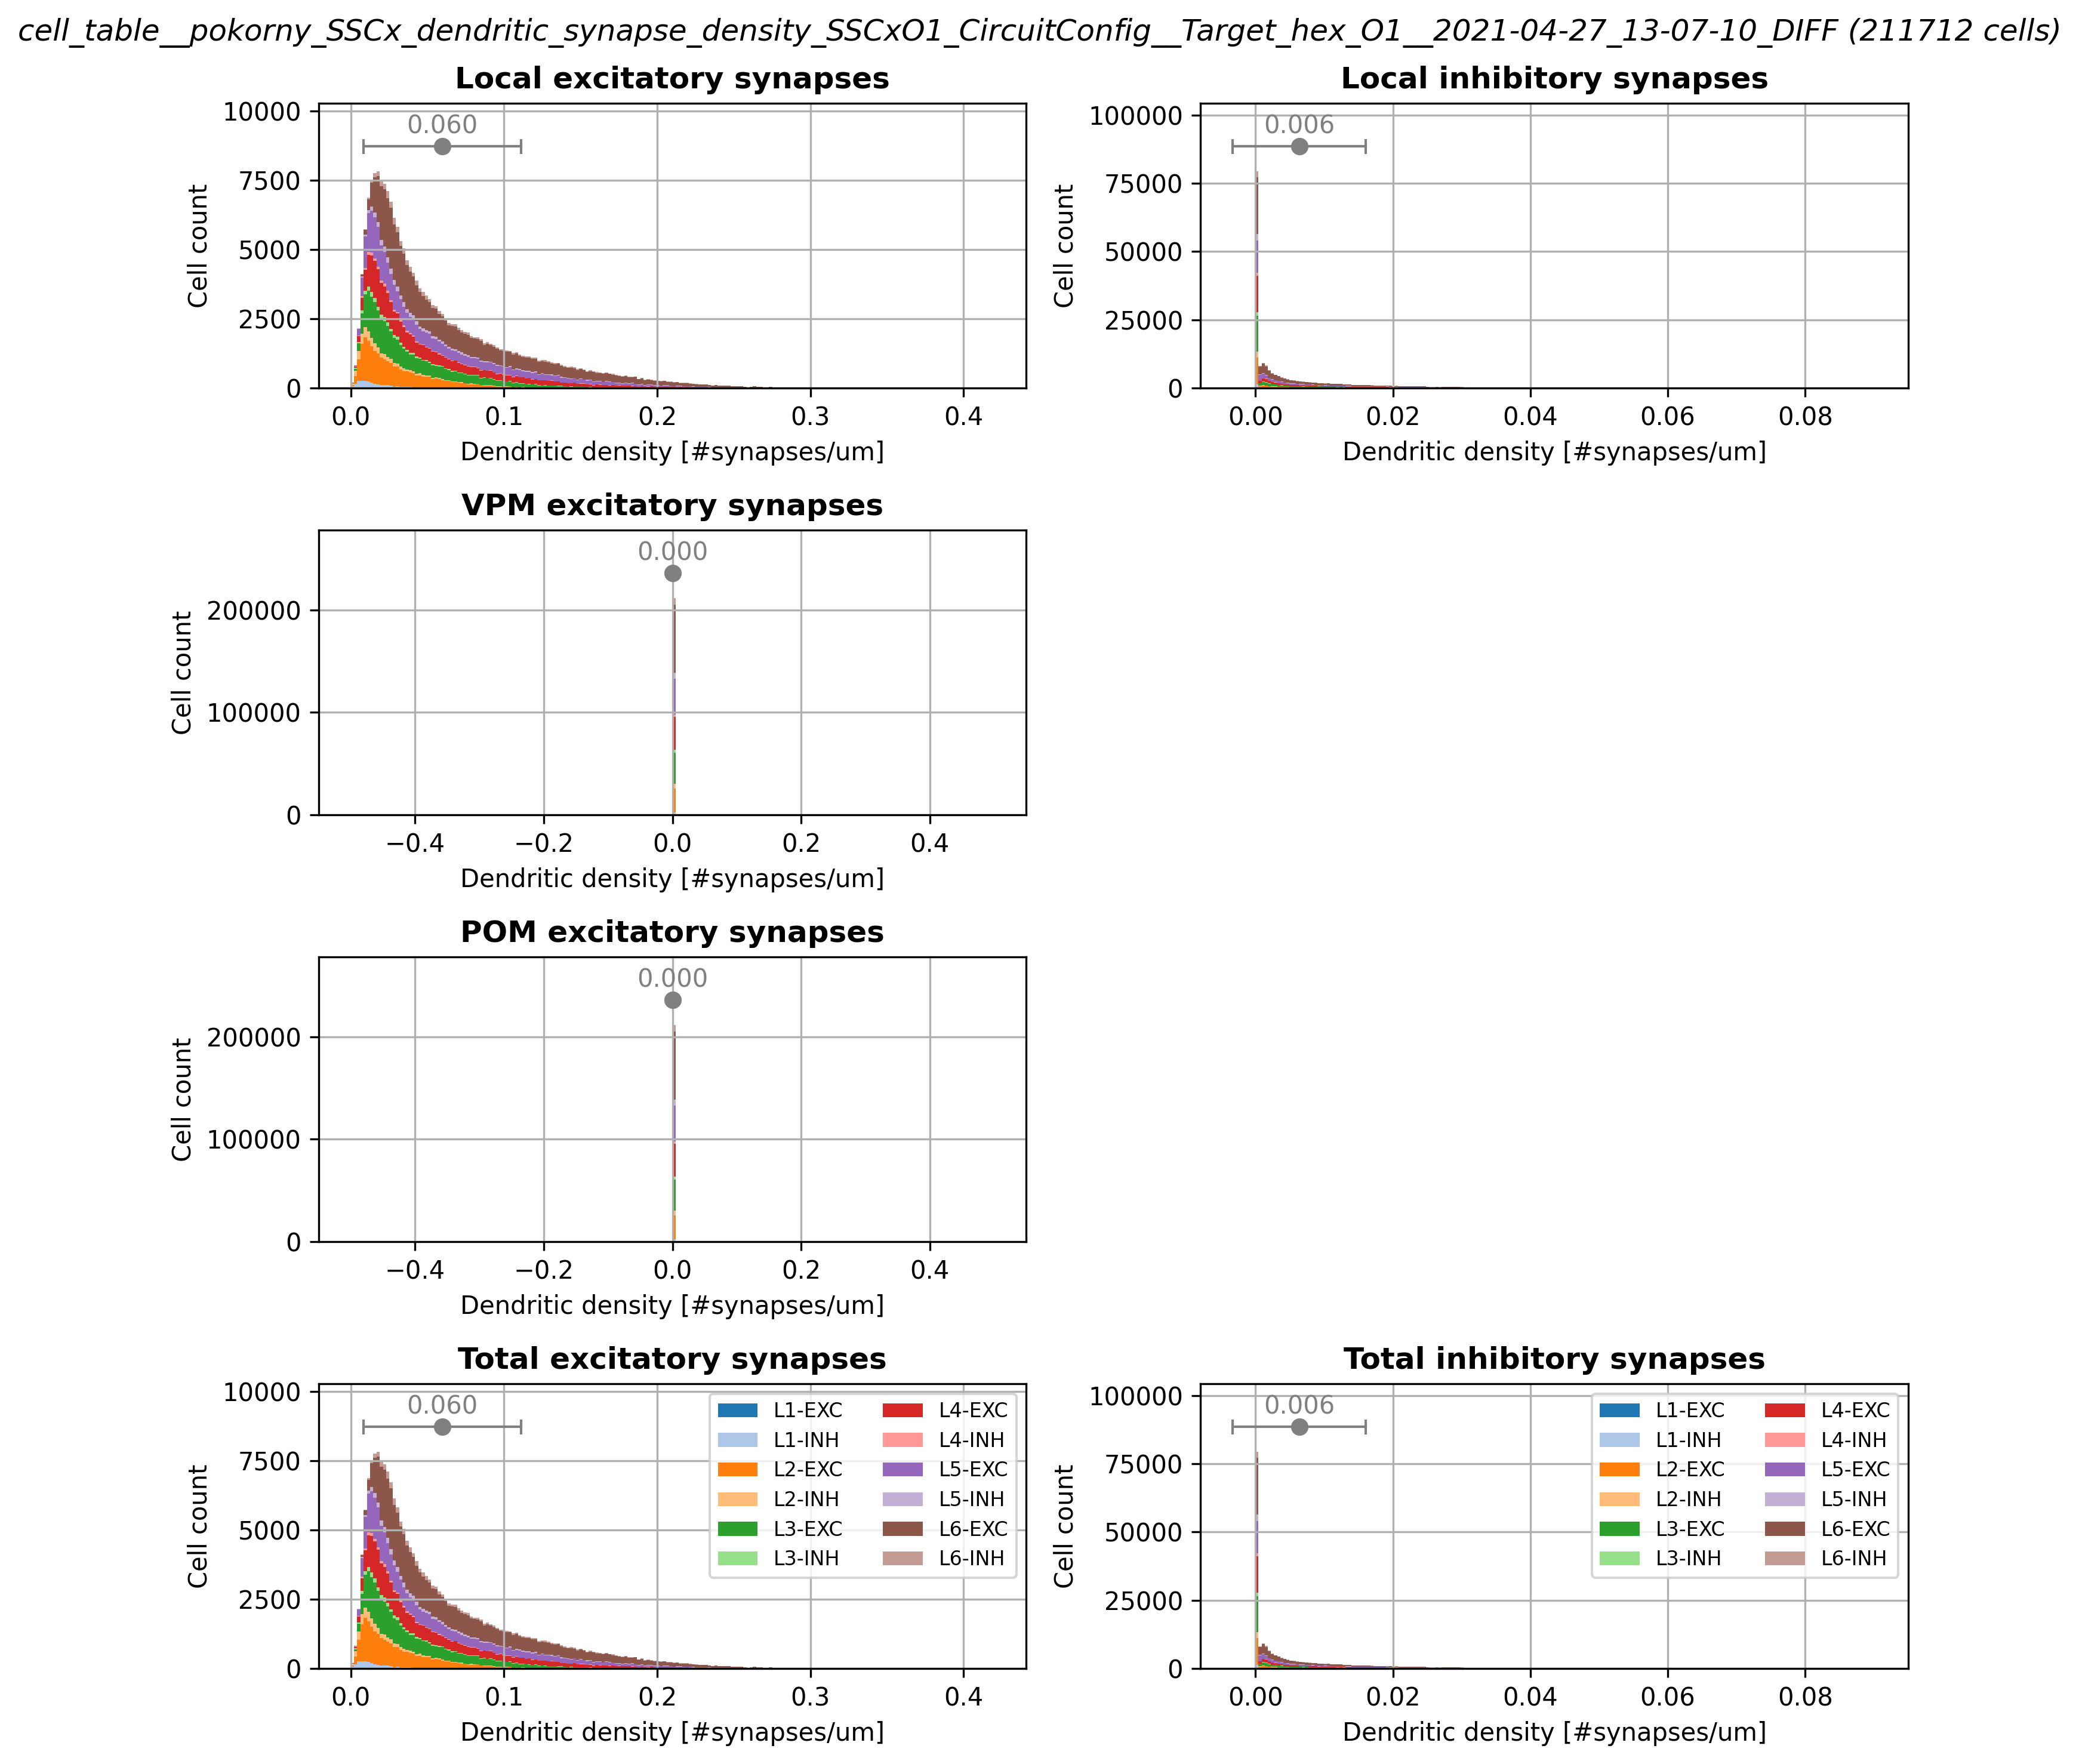

In [36]:
# Density histograms grouped per post-synaptic cell type/layer/mtype/... & synapse class

# conn_sel = [[   'Local',  'local_E_syn_density', 'local_I_syn_density'],
#             [     'VPM',      'VPM_syn_density',                    ''],
#             [     'POM',      'POM_syn_density',                    ''],
#             ['Midrange', 'midrange_syn_density',                    ''],
#             [   'Total',  'total_E_syn_density', 'total_I_syn_density']]

conn_sel = [[   'Local',  'local_E_syn_density', 'local_I_syn_density'],
            [     'VPM',      'VPM_syn_density',                    ''],
            [     'POM',      'POM_syn_density',                    ''],
            [   'Total',  'total_E_syn_density', 'total_I_syn_density']]

log_count = False
step_plot = False
N_bins = 200
bar_pos = 0.25 if log_count else 0.85
group_by = 'layer'
group_by2 = 'synapse_class'

fig = plt.figure(figsize=(10, 10), dpi=300)
for conn_idx in range(len(conn_sel)):
    plot_sel = {'excitatory': {'key': conn_sel[conn_idx][1]},
                'inhibitory': {'key': conn_sel[conn_idx][2]}}
    for idx, (name, spec) in enumerate(plot_sel.items()):
        
        if len(spec['key']) == 0:
            continue
        
        plt.subplot(len(conn_sel), len(plot_sel), conn_idx * len(plot_sel) + idx + 1)
        group_values = np.unique(circuit.cells.get(properties=group_by)).tolist() #[::-1]
        group_values2 = np.unique(circuit.cells.get(properties=group_by2)).tolist() #[::-1]
        bar_offset = np.zeros(N_bins)
        group_colors = plt.cm.tab20(np.linspace(0, 1, 20))
        group_colors = group_colors[:len(group_values) * len(group_values2), :]
        for gidx, g in enumerate(group_values):
            for gidx2, g2 in enumerate(group_values2):
                gids_sel = circuit.cells.ids({group_by: g, group_by2: g2})
                if not circuit_target is None:
                    gids_sel = np.intersect1d(gids_sel, cell_ids)
                #gcol = None # Automatic coloring
                gcol = group_colors[gidx2 + gidx * len(group_values2), :]
                density_count, density_bins = np.histogram(cell_table.loc[gids_sel, spec['key']], bins=N_bins, range=(cell_table[spec['key']].min(), cell_table[spec['key']].max()))
                if step_plot:
                    plt.step(density_bins, np.hstack((density_count[0], density_count)), color=gcol, label=f'L{g}-{g2}')
                else:
                    plt.bar(density_bins[:-1], density_count, width=np.mean(np.diff(density_bins)), align='edge', color=gcol, edgecolor='none', bottom=bar_offset, label=f'L{g}-{g2}')
                    bar_offset = bar_offset + density_count
        if log_count:
            plt.gca().set_yscale('log')
        plt.ylim((min(plt.ylim()), 5 * max(plt.ylim()) if log_count else 1.25 * max(plt.ylim())))
        plt.plot(cell_table[spec['key']].mean(), bar_pos * max(plt.ylim()), 'o', color='grey')
        plt.plot([cell_table[spec['key']].mean() - cell_table[spec['key']].std(), cell_table[spec['key']].mean() + cell_table[spec['key']].std()], np.full(2, bar_pos * max(plt.ylim())), '|-', color='grey', linewidth=1.0)
        plt.text(cell_table[spec['key']].mean(), (bar_pos + 0.025) * max(plt.ylim()), '{:.3f}'.format(cell_table[spec['key']].mean()), color='grey', va='bottom', ha='center')
        plt.xlabel('Dendritic density [#synapses/um]')
        plt.ylabel('Cell count')
        plt.grid()
        plt.title(f'{conn_sel[conn_idx][0]} {name} synapses', fontweight='bold')
        if conn_idx == len(conn_sel) - 1:
            plt.legend(fontsize=8, loc='upper right', ncol=2)
plt.suptitle(f'{circuit_config} ({cell_table.shape[0]} cells)', fontstyle='italic')
plt.tight_layout()
plt.savefig(f'./density_histograms_{group_by}-{group_by2}{"_log" if log_count else ""}{"_step" if step_plot else ""}__{circuit_name}__{save_date}.png')

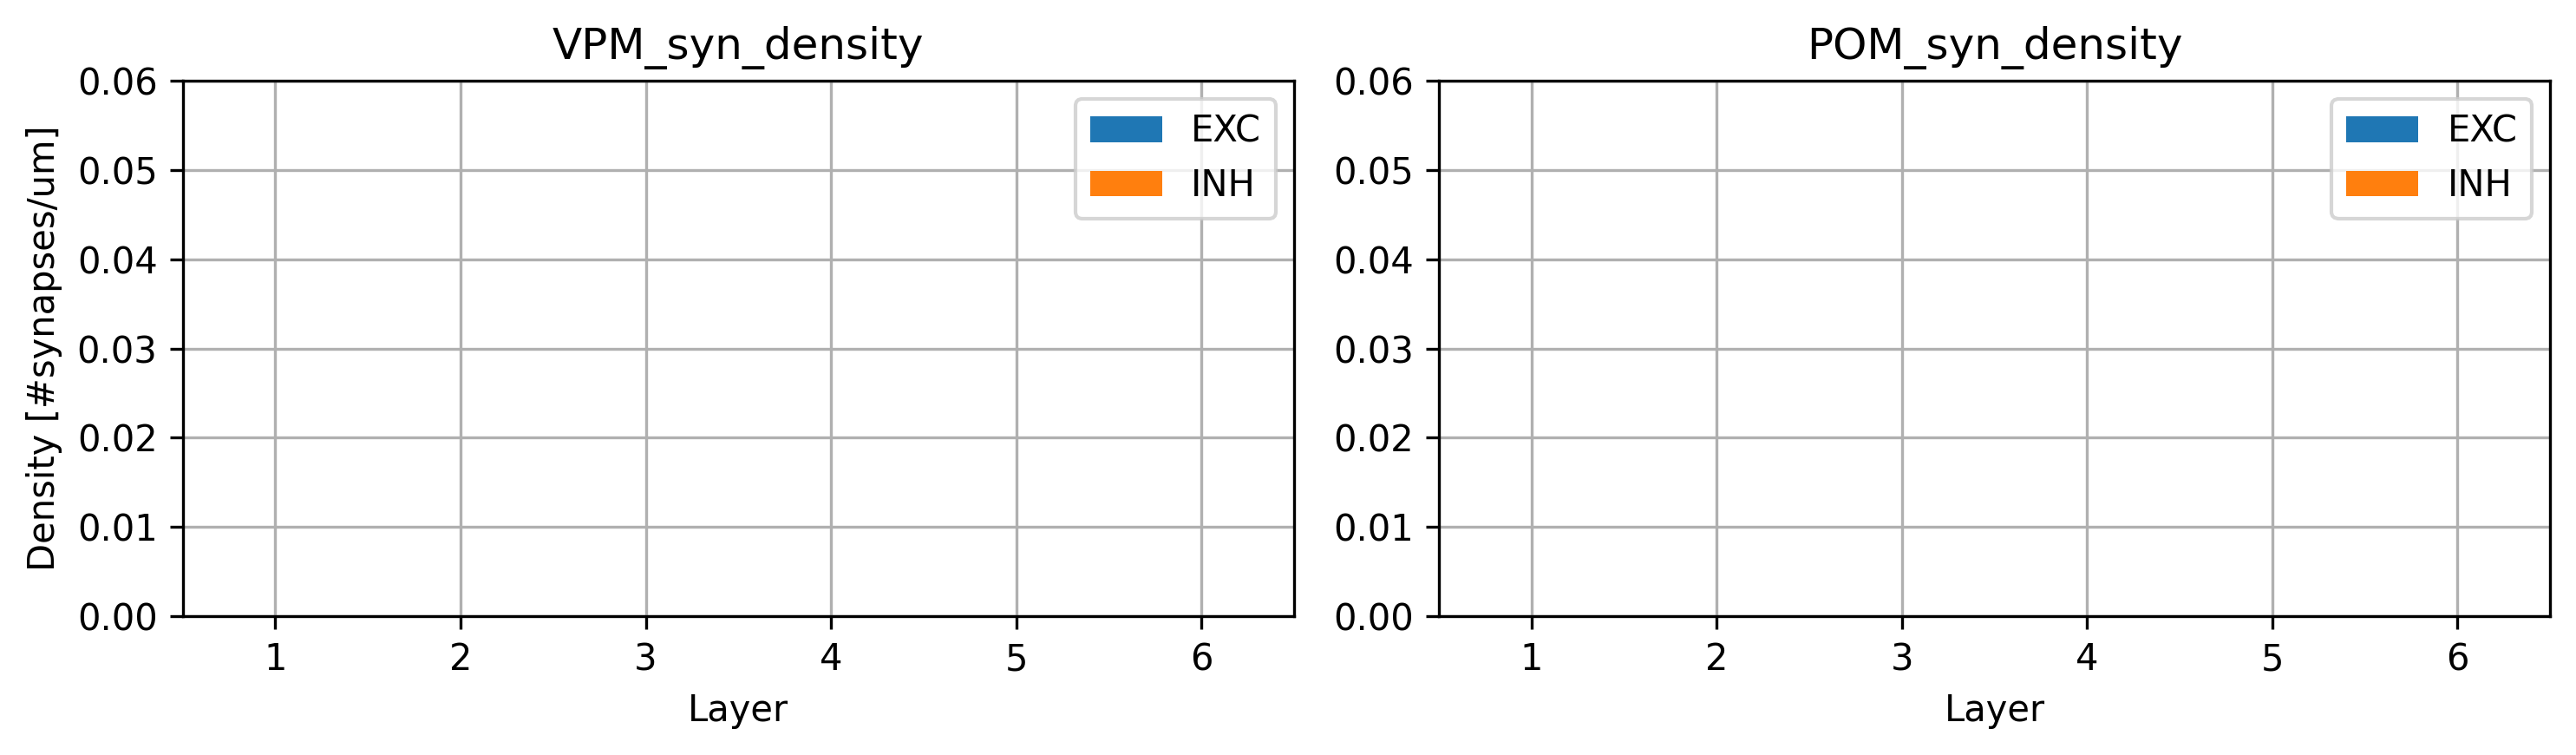

In [37]:
# TC synapse densities on EXC/INH neurons
layers = np.unique(circuit.cells.get(properties='layer'))
cell_types = np.unique(circuit.cells.get(properties='synapse_class'))
tc_sel = ['VPM_syn_density', 'POM_syn_density']
fig = plt.figure(figsize=(10, 3), dpi=300)
for tc_idx, tc in enumerate(tc_sel):
    plt.subplot(1, len(tc_sel), tc_idx + 1)
    for tp_idx, tp in enumerate(cell_types):
        gids_sel = [np.intersect1d(circuit.cells.ids({'layer': lay, 'synapse_class': tp}), cell_table.index) for lay in layers]
        syn_dens_mean = [np.mean(cell_table.loc[gids_sel[i], tc]) for i in range(len(layers))]
        syn_dens_std = [np.std(cell_table.loc[gids_sel[i], tc]) for i in range(len(layers))]
        plt.bar(layers - 0.4 + tp_idx * 0.8 / len(cell_types), syn_dens_mean, width=0.375, label=tp)
        #plt.errorbar(layers - 0.4 + tp_idx * 0.8 / len(cell_types), syn_dens_mean, yerr=syn_dens_std, fmt='.k')
    plt.title(tc)
    plt.legend()
    plt.xlabel('Layer')
    if tc_idx == 0:
        plt.ylabel('Density [#synapses/um]')
    plt.xlim((min(layers) - 0.5, max(layers) + 0.5))
    plt.ylim((0.0, 0.06))
    #plt.ylim((0.0, 0.12))
    plt.grid(True)
plt.tight_layout()
plt.savefig(f'./mean_TC_densities__{circuit_name}__{save_date}.png')

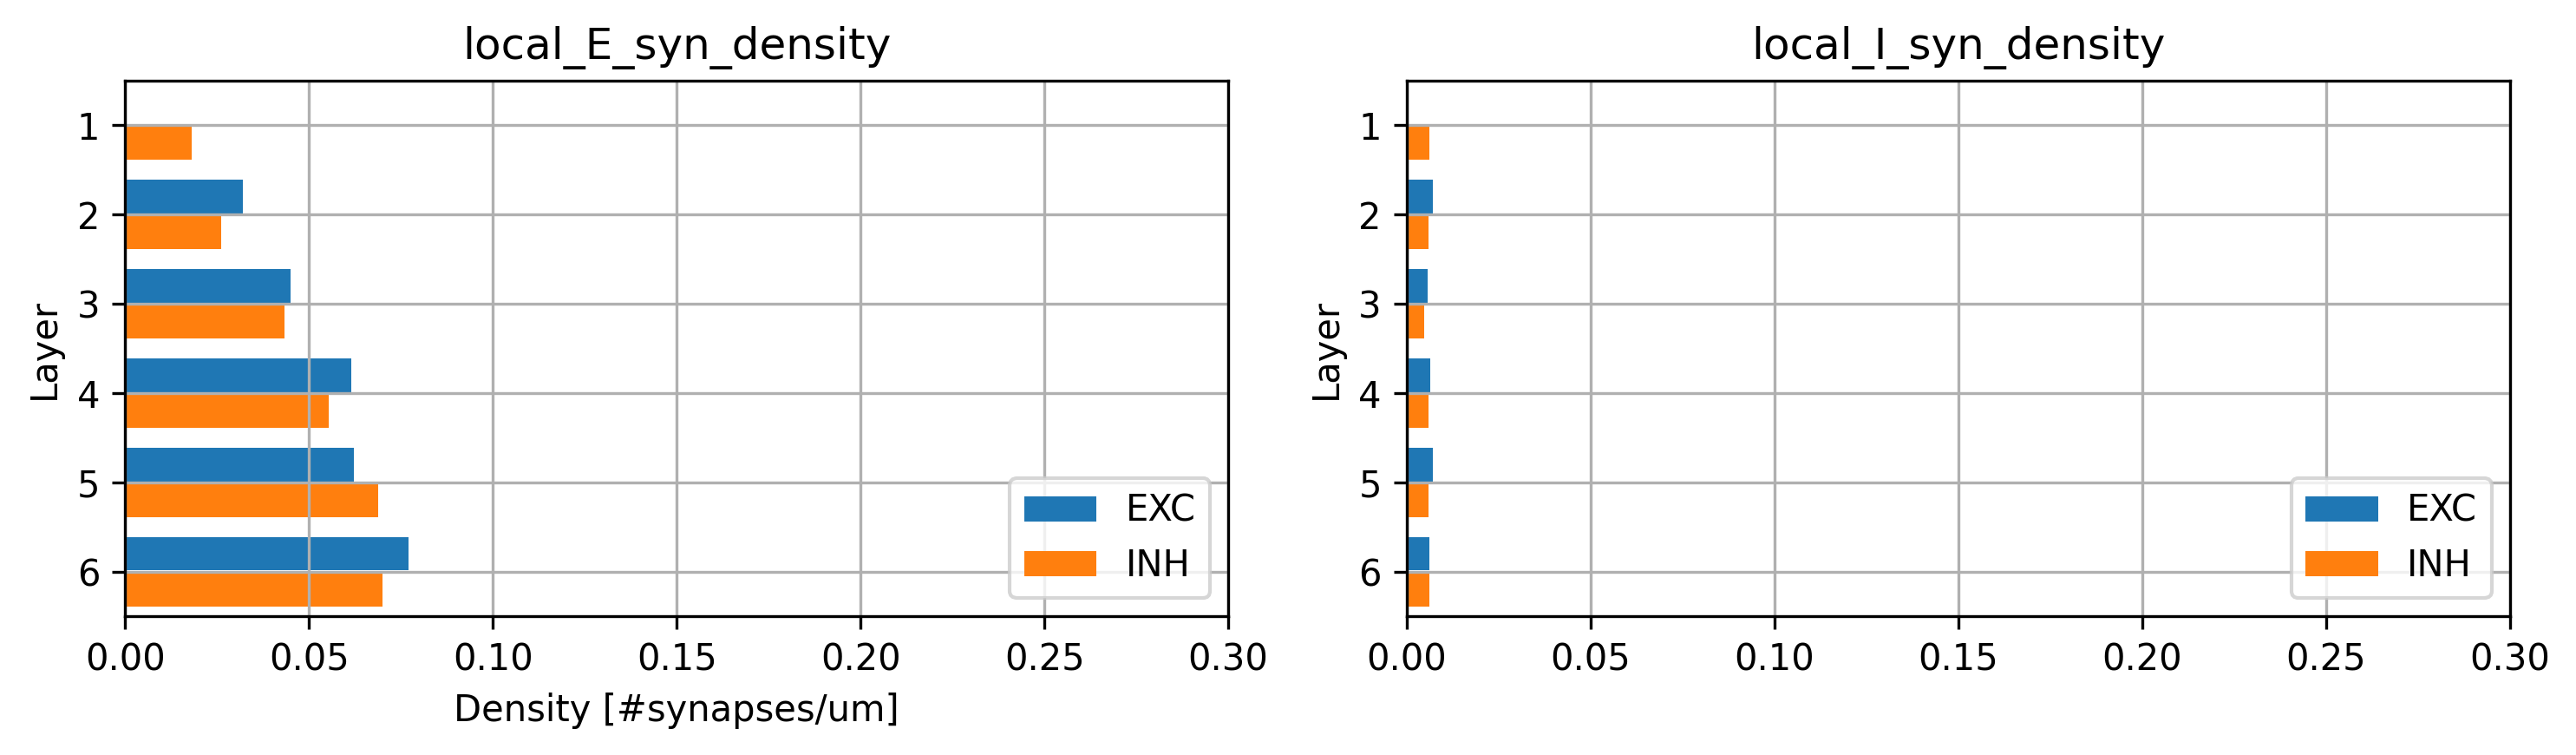

In [38]:
# Local synapse densities on EXC/INH neurons
layers = np.unique(circuit.cells.get(properties='layer'))
cell_types = np.unique(circuit.cells.get(properties='synapse_class'))
syn_sel = ['local_E_syn_density', 'local_I_syn_density']
fig = plt.figure(figsize=(10, 3), dpi=300)
for idx, sel in enumerate(syn_sel):
    plt.subplot(1, len(syn_sel), idx + 1)
    for tp_idx, tp in enumerate(cell_types):
        gids_sel = [np.intersect1d(circuit.cells.ids({'layer': lay, 'synapse_class': tp}), cell_table.index) for lay in layers]
        syn_dens_mean = [np.mean(cell_table.loc[gids_sel[i], sel]) for i in range(len(layers))]
        syn_dens_std = [np.std(cell_table.loc[gids_sel[i], sel]) for i in range(len(layers))]
        plt.barh(layers - 0.2 + tp_idx * 0.8 / len(cell_types), syn_dens_mean, height=0.375, label=tp)
        #plt.errorbar(layers - 0.4 + tp_idx * 0.8 / len(cell_types), syn_dens_mean, yerr=syn_dens_std, fmt='.k')
    plt.title(sel)
    plt.legend()
    if idx == 0:
        plt.xlabel('Density [#synapses/um]')
    plt.xlim((0.0, 0.3))
    plt.ylabel('Layer')
    plt.ylim((min(layers) - 0.5, max(layers) + 0.5))    
    plt.gca().invert_yaxis()
    plt.grid(True)
plt.tight_layout()
plt.savefig(f'./mean_local_densities__{circuit_name}__{save_date}.png')

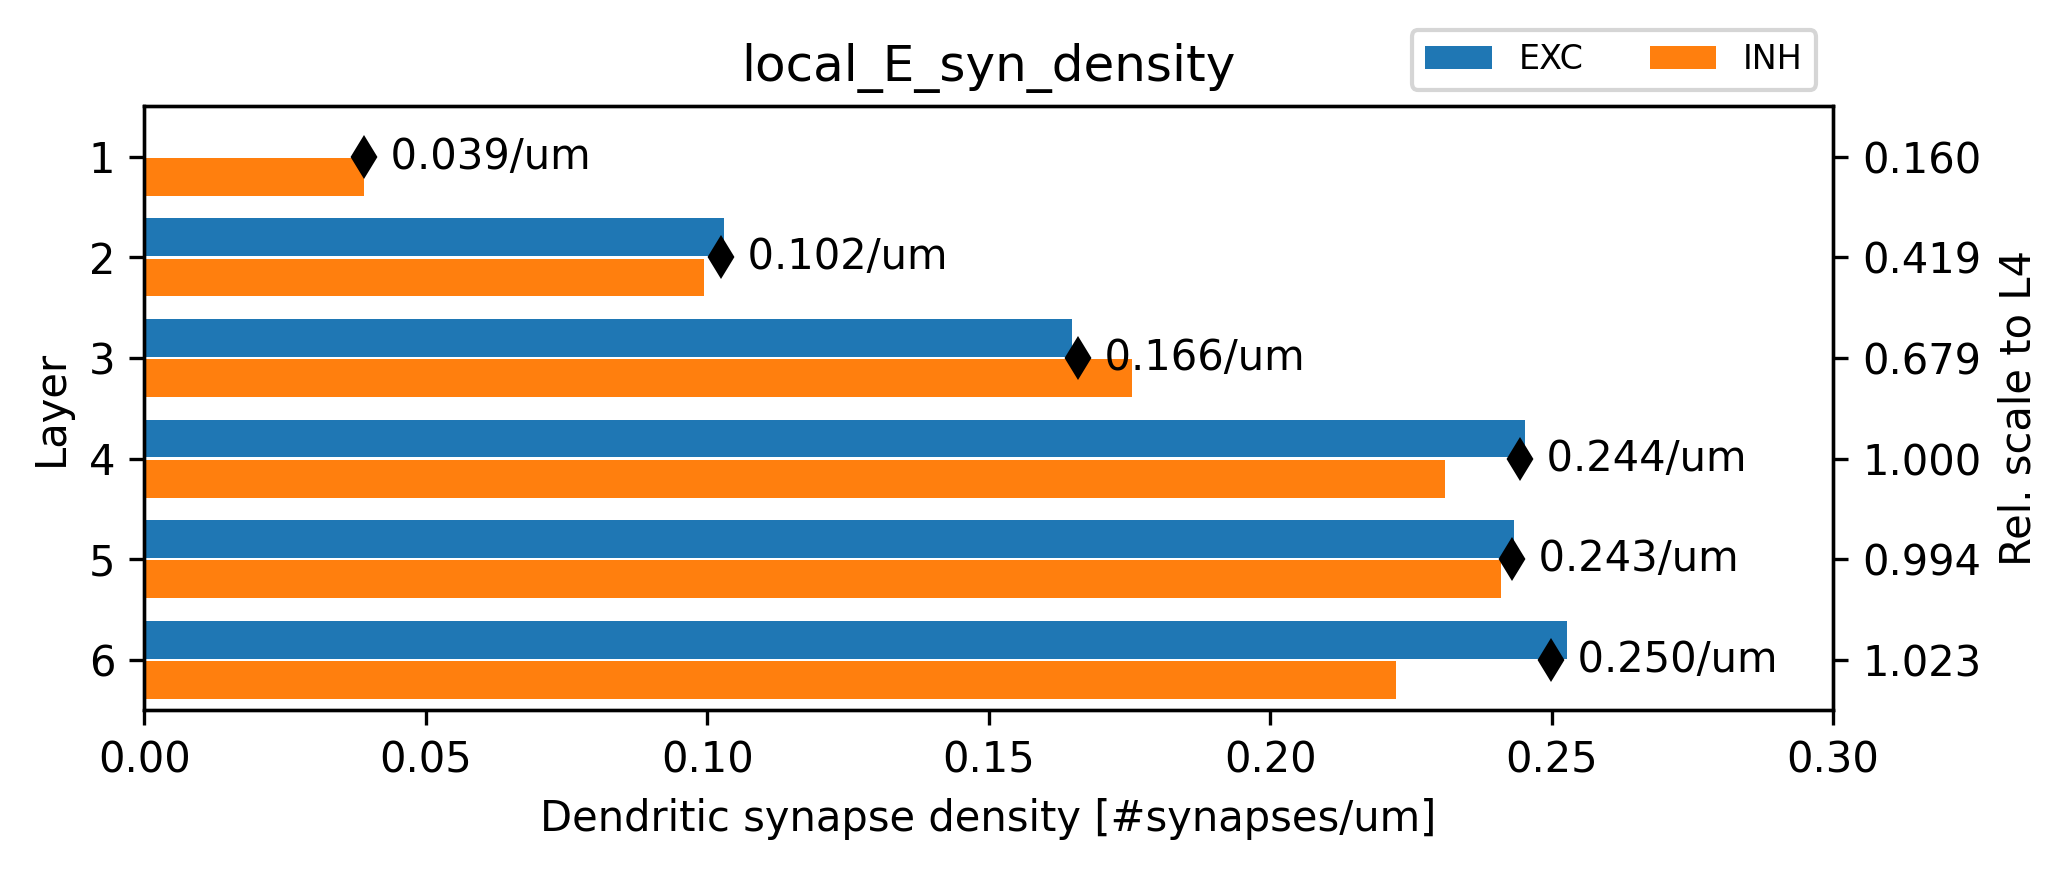

In [58]:
# Local EXC synapse densities (overall)
layers = np.unique(circuit.cells.get(properties='layer'))
cell_types = np.unique(circuit.cells.get(properties='synapse_class'))
syn_sel = ['local_E_syn_density']
fig = plt.figure(figsize=(7, 3), dpi=300)
for idx, sel in enumerate(syn_sel):
    plt.subplot(1, len(syn_sel), idx + 1)
    for tp_idx, tp in enumerate(cell_types):
        gids_sel = [np.intersect1d(circuit.cells.ids({'layer': lay, 'synapse_class': tp}), cell_table.index) for lay in layers]
        syn_dens_mean = [np.mean(cell_table.loc[gids_sel[i], sel]) for i in range(len(layers))]
        syn_dens_std = [np.std(cell_table.loc[gids_sel[i], sel]) for i in range(len(layers))]
        plt.barh(layers - 0.2 + tp_idx * 0.8 / len(cell_types), syn_dens_mean, height=0.375, label=tp)
    gids_sel = [np.intersect1d(circuit.cells.ids({'layer': lay}), cell_table.index) for lay in layers]
    syn_dens_mean = [np.mean(cell_table.loc[gids_sel[i], sel]) for i in range(len(layers))]
    syn_dens_std = [np.std(cell_table.loc[gids_sel[i], sel]) for i in range(len(layers))]
    plt.plot(syn_dens_mean, layers, 'dk')
    plt.title(sel)
    if idx == 0:
        plt.xlabel('Dendritic synapse density [#synapses/um]')
    plt.xlim((0.0, 0.3)) # 0.35
    plt.ylabel('Layer')
    plt.ylim((min(layers) - 0.5, max(layers) + 0.5))
    plt.gca().invert_yaxis()
    plt.legend(loc='lower right', ncol=2, bbox_to_anchor=[1.0, 1.0], fontsize=8)
    #plt.grid(True)
    for lidx, lay in enumerate(layers):
        plt.text(syn_dens_mean[lidx], lay, f'  {syn_dens_mean[lidx]:.3f}/um', color='k', ha='left', va='center')
#         plt.text(max(plt.xlim()), lay, f'{syn_dens_mean[lidx] / syn_dens_mean[3]:.3f} ', color='k', ha='right', va='center')
    ax2 = plt.gca().twinx()
    ax2.set_yticks(layers)
    ax2.set_yticklabels([f'{syn_dens_mean[lidx] / syn_dens_mean[3]:.3f}' for lidx in range(len(layers))])
    ax2.set_ylim((min(layers) - 0.5, max(layers) + 0.5))
    ax2.set_ylabel('Rel. scale to L4')
    ax2.invert_yaxis()
plt.tight_layout()
plt.savefig(f'./mean_local_EXC_densities__{circuit_name}__{save_date}.png')

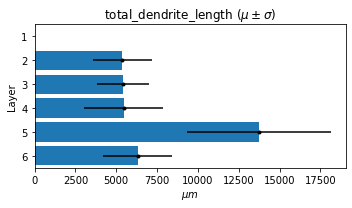

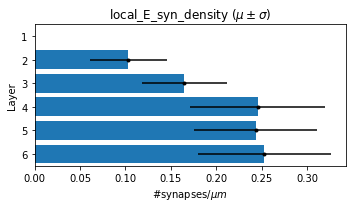

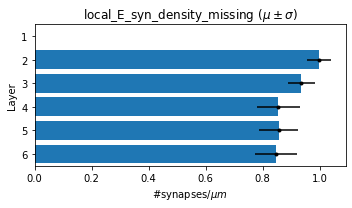

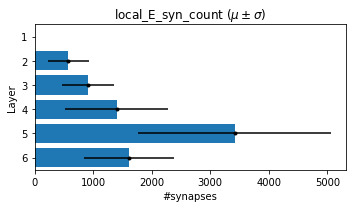

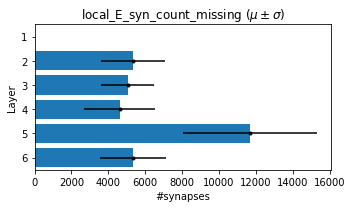

In [7]:
# Plot missing synapses
layers = np.unique(circuit.cells.get(properties='layer'))
plot_sel = ['total_dendrite_length', 'local_E_syn_density', 'local_E_syn_density_missing', 'local_E_syn_count', 'local_E_syn_count_missing']
plot_units = ['$\mu m$', '#synapses/$\mu m$', '#synapses/$\mu m$', '#synapses', '#synapses']
for key, unit in zip(plot_sel, plot_units):
    fig = plt.figure(figsize=(5, 3))
    gids_sel = [np.intersect1d(circuit.cells.ids({'layer': lay, 'synapse_class': 'EXC'}), cell_table.index) for lay in layers]
    syn_val_mean = [np.mean(cell_table.loc[gids_sel[i], key]) for i in range(len(layers))]
    syn_val_std = [np.std(cell_table.loc[gids_sel[i], key]) for i in range(len(layers))]
    plt.barh(layers, syn_val_mean)
    plt.errorbar(syn_val_mean, layers, xerr=syn_val_std, fmt='.k')
    plt.title(key + ' ($\mu \pm \sigma$)')
    plt.xlabel(unit)
    plt.ylabel('Layer')
    plt.ylim((min(layers) - 0.5, max(layers) + 0.5))
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f'./mean_{key}__{circuit_name}__{save_date}.png', dpi=300)

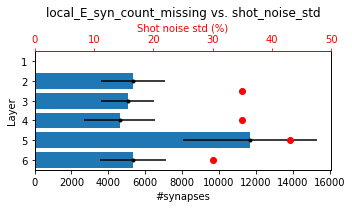

In [58]:
# Relate with input compensation (shot noise)
layers = np.unique(circuit.cells.get(properties='layer'))
plot_sel = ['local_E_syn_count_missing']
plot_units = ['#synapses']
shot_noise_layers = [2.5, 4, 5, 6]
# shot_noise_means = [70, 70, 70, 70]
shot_noise_stds = [35, 35, 43, 30]
shot_noise_unit = '%'
for key, unit in zip(plot_sel, plot_units):
    fig = plt.figure(figsize=(5, 3))
    gids_sel = [np.intersect1d(circuit.cells.ids({'layer': lay, 'synapse_class': 'EXC'}), cell_table.index) for lay in layers]
    syn_val_mean = [np.mean(cell_table.loc[gids_sel[i], key]) for i in range(len(layers))]
    syn_val_std = [np.std(cell_table.loc[gids_sel[i], key]) for i in range(len(layers))]
    plt.barh(layers, syn_val_mean)
    plt.errorbar(syn_val_mean, layers, xerr=syn_val_std, fmt='.k')
    plt.title(key + ' vs. shot_noise_std')
    plt.xlabel(unit)
    plt.ylabel('Layer')
    plt.ylim((min(layers) - 0.5, max(layers) + 0.5))
    plt.gca().invert_yaxis()
    
    ax2 = plt.gca().twiny()
    ax2.set_yticks(layers)
    ax2.set_xlim((0, 50))
    ax2.set_ylim((min(layers) - 0.5, max(layers) + 0.5))
    ax2.set_xlabel(f'Shot noise std ({shot_noise_unit})', color='r')
    ax2.spines['top'].set_color('r')
    ax2.tick_params(axis='x', colors='r')
    ax2.invert_yaxis()
    ax2.plot(shot_noise_stds, shot_noise_layers, 'or')
    plt.tight_layout()
    plt.savefig(f'./mean_{key}_vs_shotnoise__{circuit_name}__{save_date}.png', dpi=300)

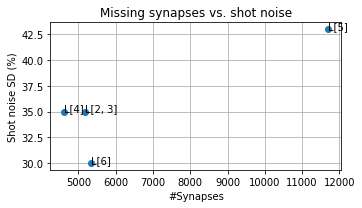

In [59]:
# Scatter plot
layers_sel = [[2, 3], 4, 5, 6]
# gids_sel = [[np.intersect1d(circuit.cells.ids({'layer': lay, 'synapse_class': 'EXC'}), cell_table.index) for lay in lay_sel] for lay_sel in layers_sel]
# gids_sel = [np.unique(np.concatenate(g)) for g in gids_sel]
gids_sel = [np.intersect1d(circuit.cells.ids({'layer': lay, 'synapse_class': 'EXC'}), cell_table.index) for lay in layers_sel]
syn_val_mean = [np.mean(cell_table.loc[gids_sel[i], 'local_E_syn_count_missing']) for i in range(len(layers_sel))]
fig = plt.figure(figsize=(5, 3))
plt.plot(syn_val_mean, shot_noise_stds, 'o')
for lidx, lay in enumerate(layers_sel):
    plt.text(syn_val_mean[lidx], shot_noise_stds[lidx], f'L{lay}')
plt.xlabel('#Synapses')
plt.ylabel('Shot noise SD (%)')
plt.title('Missing synapses vs. shot noise')
plt.grid(True)
plt.tight_layout()
plt.savefig(f'./mean_{key}_vs_shotnoise_scatter__{circuit_name}__{save_date}.png', dpi=300)

### Extract dendritic densities within notebook [FOR TESTING PURPOSES]

In [ ]:
# Disable deprecation/user warnings
import warnings
from bluepysnap.exceptions import BluepySnapDeprecationWarning
warnings.filterwarnings("ignore", category=BluepySnapDeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [5]:
# Create table with cell positions and dentritic synapse density for given set of GIDs [for easy parallelization]
def create_cell_table(circuit_config, N_split, split_idx):
    
    # Load circuit
    circuit = Circuit(circuit_config)
    cell_ids = circuit.cells.ids()
    cell_ids_split = np.split(cell_ids, np.cumsum([np.ceil(len(cell_ids) / N_split).astype(int)] * (N_split - 1)))
    gids = cell_ids_split[split_idx]
    num_cells = len(gids)
    proj_names = list(circuit.config['projections'].keys())
    
    print(f'Creating cell table (incl. {len(proj_names)} projections) for {num_cells} cells: {gids[:3]}..{gids[-3:]}', flush=True)
    
    # Extract cell positions
    cell_table = circuit.cells.get(gids, properties=[Cell.X, Cell.Y, Cell.Z])
    
    # Get dendrite length & number of afferent (dendritic) synapses
    cell_table.insert(column='total_dendrite_length', value=np.nan, loc=cell_table.shape[1])
    cell_table.insert(column='local_E_syn_count', value=-1, loc=cell_table.shape[1])
    cell_table.insert(column='local_I_syn_count', value=-1, loc=cell_table.shape[1])
    
    for p in proj_names:
        cell_table.insert(column=p + '_count', value=-1, loc=cell_table.shape[1])
    
    for idx, gid in enumerate(gids):
        
        # Query morphology
        nrn = circuit.morph.get(gid)
        cell_table.at[gid, 'total_dendrite_length'] = nm.get('total_length', nrn, neurite_type=nm.BASAL_DENDRITE) + nm.get('total_length', nrn, neurite_type=nm.APICAL_DENDRITE)
        
        # Query local connectivity
        syn = circuit.connectome.afferent_synapses(gid, properties=[Synapse.POST_BRANCH_TYPE, Synapse.TYPE])
        cell_table.at[gid, 'local_E_syn_count'] = np.sum(np.logical_and(syn[Synapse.TYPE] >= 100, np.logical_or(syn[Synapse.POST_BRANCH_TYPE] == NeuriteType.apical_dendrite, syn[Synapse.POST_BRANCH_TYPE] == NeuriteType.basal_dendrite)))
        cell_table.at[gid, 'local_I_syn_count'] = np.sum(np.logical_and(syn[Synapse.TYPE] < 100, np.logical_or(syn[Synapse.POST_BRANCH_TYPE] == NeuriteType.apical_dendrite, syn[Synapse.POST_BRANCH_TYPE] == NeuriteType.basal_dendrite)))
        
        # Query projections
        # | Properties not available: Synapse.POST_BRANCH_TYPE, Synapse.TYPE
        # | => ASSUME: Only one type of synapses, targeting dendrites
        for p in proj_names:
            cell_table.at[gid, p + '_count'] = len(circuit.projection(p).afferent_synapses(gid))
    
    # Compute dendritic synapse density
    cell_table.insert(column='local_E_syn_density', value=cell_table['local_E_syn_count'] / cell_table['total_dendrite_length'], loc=cell_table.shape[1])
    cell_table.insert(column='local_I_syn_density', value=cell_table['local_I_syn_count'] / cell_table['total_dendrite_length'], loc=cell_table.shape[1])
    for p in proj_names:
        cell_table.insert(column=p + '_density', value=cell_table[p + '_count'] / cell_table['total_dendrite_length'], loc=cell_table.shape[1])
    
    return cell_table

In [6]:
# Specify circuit
circuit_config = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1/CircuitConfig'
# circuit_config = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build/CircuitConfig'
# circuit_config = '/gpfs/bbp.cscs.ch/project/proj1/circuits/SomatosensoryCxS1-v5.r0/O1/merged_circuit/CircuitConfig'
# circuit_config = '/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig'
# circuit_config = '/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig_TCv2'
# circuit_config = '/gpfs/bbp.cscs.ch/project/proj83/circuits/Bio_M/20200805/CircuitConfig_TCv2_WM'

# Run in parallel
N_jobs = 4
N_split = N_jobs * 4
t_start = time.time()
cell_table = pd.concat(Parallel(n_jobs=N_jobs, verbose=100)(delayed(create_cell_table)(circuit_config, N_split, idx) for idx in range(N_split)))
print(f'Time elapsed ({cell_table.shape[0]} cells): {time.time() - t_start:.0f}s')

# Save table
circuit_name = '_'.join(circuit_config.split('/')[-4:-1]) # Extract circuit name from path
save_date = datetime.today().strftime('%Y-%m-%d_%H-%M-%S')
save_path = f'./cell_table__{circuit_name}__{save_date}.pkl'

cell_table.to_pickle(save_path)
print(f'Cell table saved to "{save_path}"')

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 tasks      | elapsed:   22.3s
[Parallel(n_jobs=4)]: Done   2 tasks      | elapsed:   24.9s
[Parallel(n_jobs=4)]: Done   3 tasks      | elapsed:   25.2s
[Parallel(n_jobs=4)]: Done   4 tasks      | elapsed:   25.8s
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done   6 tasks      | elapsed:   45.7s
[Parallel(n_jobs=4)]: Done   7 tasks      | elapsed:   46.2s
[Parallel(n_jobs=4)]: Done   8 tasks      | elapsed:   51.2s
[Parallel(n_jobs=4)]: Done   9 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done  10 out of  16 | elapsed:  1.1min remaining:   41.1s
[Parallel(n_jobs=4)]: Done  11 out of  16 | elapsed:  1.2min remaining:   31.4s
[Parallel(n_jobs=4)]: Done  12 out of  16 | elapsed:  1.2min remaining:   24.1s
[Parallel(n_jobs=4)]: Done  13 out of  16 | elapsed:  1.4min remaining:   19.9s
[Parallel(n_jobs=4)]: Done  14 out of  16 | elapsed:  1.

In [ ]:
# *** OLD IMPLEMENTATION [w/o parallelization] ***

In [5]:
# # Load circuit
# circuit_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build-S1_v1'
# # circuit_path = '/gpfs/bbp.cscs.ch/data/scratch/proj83/home/pokorny/circuit-build'
# c = Circuit(circuit_path + '/CircuitConfig')

In [3]:
# # Create cell table
# cell_table = c.cells.get(properties=[Cell.X, Cell.Y, Cell.Z])
# num_cells = cell_table.shape[0]

# print(f'Circuit with {num_cells} cells')

In [4]:
# # Get dendrite length [SLOW]
# t_start = time.time()
# pbar = progressbar.ProgressBar()
# cell_table.insert(column='dendrite_length', value=np.nan, loc=cell_table.shape[1])
# for idx in pbar(range(num_cells)):
#     gid = cell_table.index[idx]
#     sect = c.morph.section_features(gid, [Section.NEURITE_TYPE, Section.LENGTH])
#     cell_table.at[gid, 'dendrite_length'] = sect.loc[np.logical_or(sect[Section.NEURITE_TYPE] == NeuriteType.basal_dendrite, sect[Section.NEURITE_TYPE] == NeuriteType.apical_dendrite), Section.LENGTH].sum()
# print(f'Time esapsed: {time.time() - t_start:.0f}s')

In [ ]:
# # Get dendrite length & number of afferent (dendritic) synapses
# cell_table.insert(column='dendrite_length', value=np.nan, loc=cell_table.shape[1])
# cell_table.insert(column='dendritic_synapse_count', value=0, loc=cell_table.shape[1])
# t_start = time.time()
# pbar = progressbar.ProgressBar()
# for idx in pbar(range(num_cells)):
#     gid = cell_table.index[idx]
    
#     # Query morphology
#     nrn = c.morph.get(gid)
#     cell_table.at[gid, 'dendrite_length'] = nm.get('total_length', nrn, neurite_type=nm.BASAL_DENDRITE) + nm.get('total_length', nrn, neurite_type=nm.APICAL_DENDRITE)
    
#     # Query connectivity
#     syn = c.connectome.afferent_synapses(gid, properties=Synapse.POST_BRANCH_TYPE)
#     cell_table.at[gid, 'dendritic_synapse_count'] = np.sum(np.logical_or(syn == NeuriteType.apical_dendrite, syn == NeuriteType.basal_dendrite))

# # Compute dendritic synapse density
# cell_table.insert(column='synapse_density', value=cell_table['dendritic_synapse_count'] / cell_table['dendrite_length'], loc=cell_table.shape[1])

# print(f'Time esapsed ({num_cells} cells): {time.time() - t_start:.0f}s')